# Transfer Learning

Inspired by: https://github.com/openai/openai-cookbook/blob/main/examples/Customizing_embeddings.ipynb

In [18]:
# imports
from typing import List, Tuple  # for type hints

import numpy as np  # for manipulating arrays
import pandas as pd  # for manipulating data in dataframes
import plotly.express as px  # for plots
import random  # for generating run IDs
from sklearn.model_selection import train_test_split  # for splitting train & test data
import torch  # for matrix optimization
import torchmetrics
import os
import datasets
from livelossplot import PlotLosses

from mteb import MTEB

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [19]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## 1. Load and process input data

In [20]:
def load_dataset_for_task(task_name: str, split: str = 'train'):
    mteb = MTEB(tasks=[task_name], task_langs=["en"])
    task = mteb.tasks[0]
    task.load_data()
    assert task.data_loaded, "Data was not loaded"
    return task.dataset[split] # Have form train, validation, test (test is used for MTEB)

def process_dataset(dataset: datasets.Dataset) -> pd.DataFrame:
    train_df = dataset.to_pandas()
    train_df = train_df[['sentence1', 'sentence2', 'score']]
    def normalize(x, min_score, max_score): # Normalise between 0 and 1 (Maybe better to do -1 and 1)
        zero_one = (x - min_score) / (max_score - min_score)
        scaled_down = zero_one / 2
        return scaled_down + 0.5
    train_df['score'] = normalize(train_df['score'], train_df['score'].min(), train_df['score'].max())
    return train_df

In [21]:
task_name = "STSBenchmark"
train_dataset = load_dataset_for_task(task_name, split='train')
val_dataset = load_dataset_for_task(task_name, split='validation')

df_train = process_dataset(train_dataset)
df_val = process_dataset(val_dataset)

df = pd.concat([df_train, df_val])

# Shuffle the data
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# Split the data
df_train, df_val = train_test_split(df, test_size=0.2, random_state=seed)

# Reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

df_train.head()

,sentence1,sentence2,score
0,A mostly black train on a track.,A car parked in front of train tracks.,0.60
1,Good cheddar has little chunks of calcium lact...,"I have two suspicions: One, you're undercookin...",0.56
2,"Their leader, Abu Bakr al-Azdi, turned himself...","Their leader, Abu Bakr al-Azdi, surrendered in...",1.00
3,A large bird standing on a table picks up a pl...,A bird picks up a plastic cup containing a liq...,0.85
4,Does he have supporters?,He definently has supporters.,0.70


## 2. Generate Synthetic Data

In [22]:
# TODO (Look at generating for dismilliar data cause all of them seem to be simialr)

## 3. Get Embeddings and Cosine Similarities

In [23]:
from model_factory import model_factory
model_name = 'voyage'

In [24]:
def generate_embedding(df: pd.DataFrame, model_name: str, task_name: str):
    model = model_factory(model_name, task_name)
    for column in ['sentence1', 'sentence2']:
        df[f"{column}_embedding"] = model.encode(df[column].tolist())

def get_cosine_similarity(a: np.array, b: np.array):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

def generate_cosine_similarity(df: pd.DataFrame):
    df['cosine_similarity'] = df.apply(lambda x: get_cosine_similarity(x['sentence1_embedding'], x['sentence2_embedding']), axis=1)

In [25]:
generate_embedding(df_train, model_name, task_name)
generate_embedding(df_val, model_name, task_name)

generate_cosine_similarity(df_train)
generate_cosine_similarity(df_val)

df_train.head()

Loading voyage from cache for STSBenchmark...
Loading voyage from cache for STSBenchmark...


,sentence1,sentence2,score,sentence1_embedding,sentence2_embedding,cosine_similarity
0,A mostly black train on a track.,A car parked in front of train tracks.,0.60,"[-0.02305222602838515, 0.036646897685474626, 0...","[-0.014578483917217323, 0.04327286383142837, -...",0.867213
1,Good cheddar has little chunks of calcium lact...,"I have two suspicions: One, you're undercookin...",0.56,"[0.005833191187747135, 0.056244062736594304, 0...","[-0.01099177110298762, 0.0304836819004032, 0.0...",0.719440
2,"Their leader, Abu Bakr al-Azdi, turned himself...","Their leader, Abu Bakr al-Azdi, surrendered in...",1.00,"[-0.03725053911231399, 0.031281256602296484, 0...","[-0.029066389786535703, 0.04169418714418918, 0...",0.973426
3,A large bird standing on a table picks up a pl...,A bird picks up a plastic cup containing a liq...,0.85,"[-0.03626237475821403, 0.03188140351815495, 0....","[-0.03071789616211613, 0.027587251426227907, 0...",0.936798
4,Does he have supporters?,He definently has supporters.,0.70,"[-0.024509472671854337, 0.04811098399928024, 0...","[-0.01610919146825513, 0.04984979513141051, 0....",0.958874


## 4. Evaluate The Baseline Performance

We use spearman and Pearson to evaluate the performance. 

Pearson correlation is a measure of strength of linear relationship between two variables. It ranges from -1 to 1.

While spearman correlation is a measure of monotonic relationship between two variables. It ranges from -1 to 1.

We want both these values to be close to 1. 


In [26]:
def get_correlation(df: pd.DataFrame, column_name: str = 'cosine_similarity'):
    return df[column_name].corr(df['score'], method='spearman'), df[column_name].corr(df['score'], method='pearson')

spearmans, pearsons = get_correlation(df_train)
print(f"Train: Spearman: {spearmans}, Pearson: {pearsons}")

spearmans, pearsons = get_correlation(df_val)
print(f"Validation: Spearman: {spearmans}, Pearson: {pearsons}")

Train: Spearman: 0.8358047837131947, Pearson: 0.8448813474663472
Validation: Spearman: 0.8268429146543711, Pearson: 0.8377721412272663


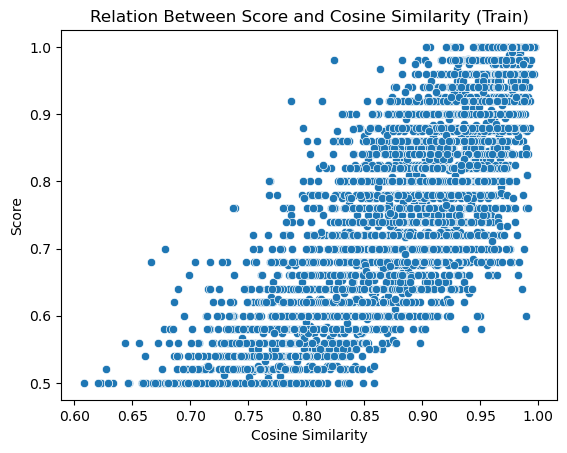

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation(df: pd.DataFrame, title: str):
    sns.scatterplot(data=df, x='cosine_similarity', y='score')
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Score')
    plt.show()

plot_correlation(df_train, 'Relation Between Score and Cosine Similarity (Train)')

# 5. Preprocessing before training



In [28]:
def get_tensors(df):
    df_x1 = np.stack(df['sentence1_embedding'].values)
    df_x2 = np.stack(df['sentence2_embedding'].values)
    df_y = df['score'].values

    X1 = torch.from_numpy(df_x1).float()
    X2 = torch.from_numpy(df_x2).float()
    Y = torch.from_numpy(df_y).float()
    return X1, X2, Y
    
X1_train, X2_train, Y_train = get_tensors(df_train)
X1_val, X2_val, Y_val = get_tensors(df_val)

# Move everything to the device
X1_train = X1_train.to(device)
X2_train = X2_train.to(device)
Y_train = Y_train.to(device)

X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
Y_val = Y_val.to(device)

# 6. Transfer Learning

Defining our Model

In [29]:
class TransformationModel(torch.nn.Module):
    def __init__(self, embedding_dim: int, embedding_output_dim: int):
        super(TransformationModel, self).__init__()
        self.linear = torch.nn.Linear(embedding_dim, embedding_output_dim)
        # TODO: can do element wise weights
    
    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        # TODO: look at normalisation
        return x

class CosineSimilarityModel(torch.nn.Module):
    def __init__(self, transformation_model: torch.nn.Module):
        super(CosineSimilarityModel, self).__init__()
        self.transformation_model = transformation_model
    
    def forward(self, embeddings1: torch.Tensor, embeddings2: torch.Tensor):
        embedding1_custom = self.transformation_model(embeddings1)
        embedding2_custom = self.transformation_model(embeddings2)
        return torch.nn.functional.cosine_similarity(embedding1_custom, embedding2_custom, dim=1)

Possible Loss Functions

In [30]:
def mse_loss(cosine_similarity: torch.Tensor, scores: torch.Tensor):
    lossF = torch.nn.MSELoss()
    return lossF(cosine_similarity, scores)

def spearman_correlation(cosine_similarity: torch.Tensor, scores: torch.Tensor):
    spearman_corr = torchmetrics.SpearmanCorrCoef()
    return spearman_corr(cosine_similarity, scores)

def pearson_correlation(cosine_similarity: torch.Tensor, scores: torch.Tensor):
    pearson_corr = torchmetrics.PearsonCorrCoef()
    return pearson_corr(cosine_similarity, scores)

Training Loop

In [31]:
def train_one_epoch(model, training_loader, optimizer, loss_function):
    running_loss = 0.

    for X1, X2, Y in training_loader:
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        cosine_sim = model(X1, X2)

        # Compute the loss and its gradients
        loss = loss_function(cosine_sim, Y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Record the loss
        running_loss += loss.item()

    average_loss = running_loss / len(training_loader)
    return average_loss


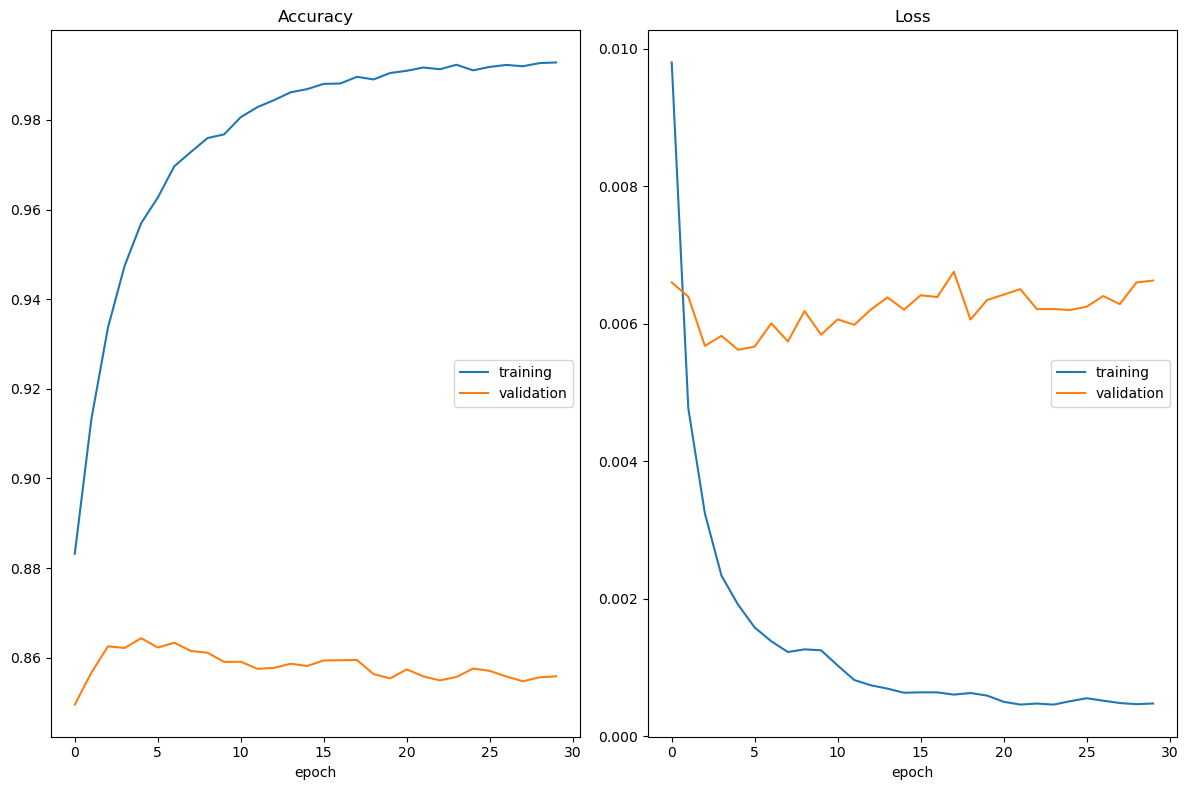

Accuracy
	training         	 (min:    0.883, max:    0.993, cur:    0.993)
	validation       	 (min:    0.850, max:    0.864, cur:    0.856)
Loss
	training         	 (min:    0.000, max:    0.010, cur:    0.000)
	validation       	 (min:    0.006, max:    0.007, cur:    0.007)


In [32]:
# Output
out_dir = 'test_results'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Hyperparameters
max_epochs = 30
lr = 0.001
batch_size = 200

# Loss function
loss_function = mse_loss

# Model
transformation_model = TransformationModel(1024, 1024)
model = CosineSimilarityModel(transformation_model)

# Move the model to the device
model = model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Data Loader
train_dataset = torch.utils.data.TensorDataset(X1_train, X2_train, Y_train)
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Keep track of losses
plotlosses = PlotLosses()

model.train()
best_val_loss = float('inf')
for _ in range(max_epochs):
    epoch_loss = train_one_epoch(model, training_loader, optimizer, loss_function)

    # Additional metrics for performance tracking
    model.eval()
    with torch.no_grad():
        # Generate the validation loss
        val_predictions = model(X1_val, X2_val)
        val_loss = loss_function(val_predictions, Y_val).item()

        # Save locally if it is the best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({'transformation_model': model.transformation_model}, f"{out_dir}/best_model.pth")

        # Compute the correlations
        train_spearman = spearman_correlation(model(X1_train, X2_train), Y_train).item()
        val_spearman = spearman_correlation(val_predictions, Y_val).item()
    model.train()

    # NTH: Save the model if it has the best validation loss (check documentation for torch.save)
    plotlosses.update({'loss': epoch_loss, 'val_loss': val_loss, 'acc': train_spearman, 'val_acc': val_spearman})
    plotlosses.send()

# 7. Evaluation

Load from memory

In [33]:
state_dict = torch.load(f"test_results/best_model.pth")
transformation_model = state_dict["transformation_model"].to(device)
model = CosineSimilarityModel(transformation_model)

In [34]:
model.eval()
with torch.no_grad():
    val_predictions = model(X1_val, X2_val)
    val_loss = loss_function(val_predictions, Y_val).item()
    val_spearman = spearman_correlation(val_predictions, Y_val).item()
    val_pearson = pearson_correlation(val_predictions, Y_val).item()

print(f"Validation Loss: {val_loss}, Validation Spearman: {val_spearman}, Validation Pearson: {val_pearson}")    

Validation Loss: 0.0056226965971291065, Validation Spearman: 0.8643673062324524, Validation Pearson: 0.8711821436882019
